## Importing Necessary Libraries

In [42]:
import numpy as np
import random
import os

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of sequential_model
from sklearn.metrics import classification_report
#   Show performance of a classification sequential_model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Concatenate

# Visualizing Model
from tensorflow.keras.utils import plot_model

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

# Modules for handling class imbalance
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE
from sklearn.utils import shuffle


#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle




## Loading Dataset

In [43]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "/kaggle/input/alz-dataset/dataset"

##  Name of classes 
CLASSES = ['MildDemented',
           'ModerateDemented',
           'NonDemented',
           'VeryMildDemented']

In [44]:
X, y = [], []
height, width = 128, 128
# Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)
# print(datagen)

#   Load images all at once by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(height, width),batch_size=6400, shuffle=True)
# print(train_dataset[0])

# Seperate dataset from  Data Generator into data and labels
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [45]:
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(6400, 128, 128, 3)


In [46]:
type(train_dataset)

keras.preprocessing.image.DirectoryIterator

## Displaying Some Images

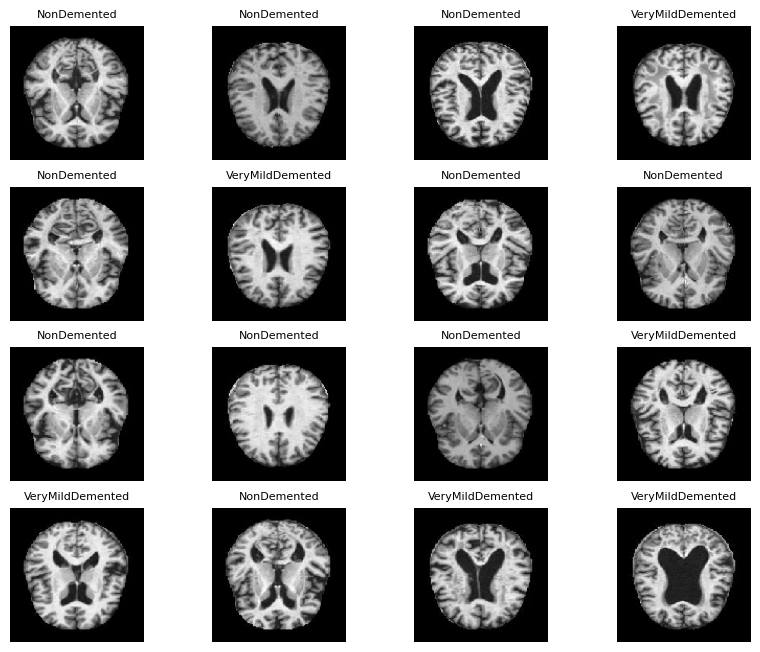

In [47]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

In [48]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6400, 128, 128, 3)
Labels shape :	 (6400, 4)


## Visualize Imbalance in Dataset

In [49]:
class_samples = sorted(Counter(np.argmax(y, axis=1)).items())
type(class_samples)

list

In [50]:
# Extract the first elements into a separate list
labels = ['MildDemented',
           'ModerateDemented',
           'NonDemented',
           'VeryMildDemented']

# Extract the second elements into another list
counts = [t[1] for t in class_samples]

print(labels)
print(counts)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
[896, 64, 3200, 2240]


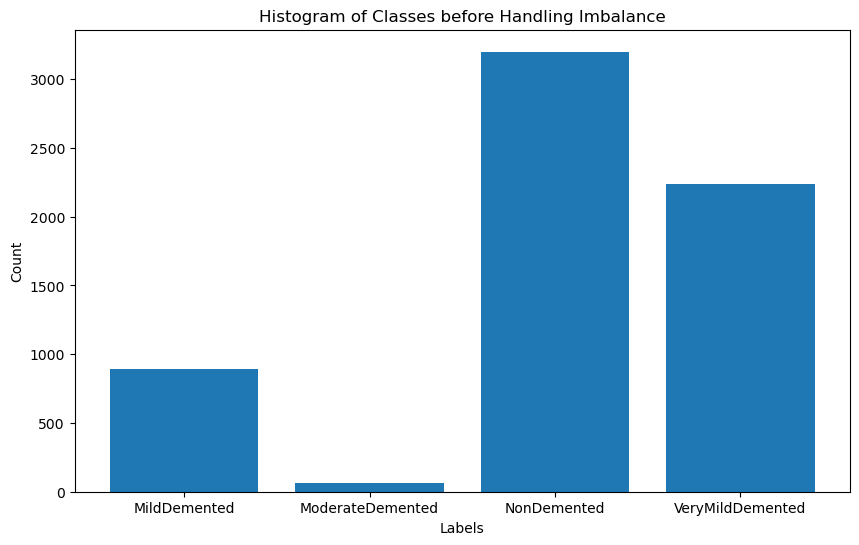

In [51]:
plt.figure(figsize=(10, 6))
# Create a histogram plot
plt.bar(labels, counts)
plt.xticks(labels)

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Histogram of Classes before Handling Imbalance')

# Display the plot
plt.show()

## Splitting Dataset into Training, Testing and Validation Sets

In [52]:
# Data shuffled while loaded so no shuffling is done while splitting data.
# 80% training data, 20 % validation data
X_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2 )

# Out of 80% training data, 20 % are taken as test data, remaining 60 % will serve as training data
X_train, x_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2 )

In [53]:
del X,y

In [54]:
# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 566), (1, 46), (2, 2046), (3, 1438)]
Validation	 [(0, 188), (1, 12), (2, 636), (3, 444)]
Test      	 [(0, 142), (1, 6), (2, 518), (3, 358)]


## Applying Oversampling Techniques to Solve Class Imbalance in the Dataset

In [55]:
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN

def balance_classes(X, y, technique):
    if technique == 'smote':
        oversampler = SMOTE(random_state=42)
    elif technique == 'smotetomek':
        oversampler = SMOTETomek(random_state=42)
    elif technique == 'smoteenn':
        oversampler = SMOTEENN(random_state=42)
    elif technique == 'adasyn':
        oversampler = ADASYN(random_state=42)
    elif technique == 'borderlinesmote':
        oversampler = BorderlineSMOTE(random_state=42)
    else:
        raise ValueError(f"Unsupported oversampling technique: {technique}")
    
    # Apply the selected oversampling technique
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    
    # Return the balanced datasets
    return X_resampled, y_resampled


In [56]:
num_samples, width, height, channels = X_train.shape
flattened_shape = width * height * channels

X_train = X_train.reshape(-1, flattened_shape)

### Choose a technique to solve class imbalance

In [57]:
X_train, y_train = balance_classes(X_train, y_train, 'smoteenn')

In [58]:
X_train = X_train.reshape(-1, width, height, channels)

In [59]:
print(X_train.shape)

(7545, 128, 128, 3)


In [60]:
print("Number of samples after removing class imbalance :\t", sorted(Counter(np.argmax(y_train, axis=1)).items()))

Number of samples after removing class imbalance :	 [(0, 2046), (1, 2046), (2, 1508), (3, 1945)]


## Visualize Dataset after Handling Class Imbalance

In [61]:
class_samples = sorted(Counter(np.argmax(y_train, axis=1)).items())
# Extract the first elements into a separate list
labels = ['MildDemented',
           'ModerateDemented',
           'NonDemented',
           'VeryMildDemented']

# Extract the second elements into another list
counts = [t[1] for t in class_samples]

print(labels)
print(counts)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
[2046, 2046, 1508, 1945]


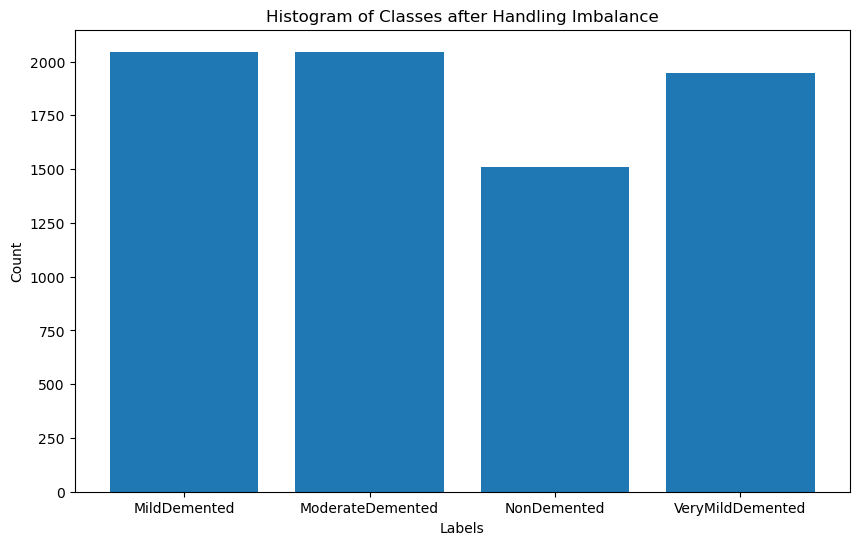

In [62]:
plt.figure(figsize=(10, 6))
# Create a histogram plot
plt.bar(labels, counts)

plt.xticks(labels)

# Add labels and title to the plot
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Histogram of Classes after Handling Imbalance')

# Display the plot
plt.show()

## Create the Model

In [63]:
from keras.initializers import GlorotUniformV2
init = GlorotUniformV2

### Function for Creating Feature Extractor

In [64]:
def create_feature_extractor(shared_input_layer, kernel_size):
    x = shared_input_layer
    units = [16, 32, 64, 128]  # No. of units of 4 convolution blocks
    for unit in units:
        x = Convolution2D(unit, kernel_size=kernel_size, kernel_initializer=init, padding='same')(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = LeakyReLU()(x)
    x = Dropout(0.01)(x)
    return x


In [65]:
# Define the input layer shared by both feature extractors
input_layer = Input(shape=(128, 128, 3))

In [66]:
# Create feature extractors that share the input layer

# Create the first feature extractor with kernel size 5, used to extract local features
feature_extractor1 = create_feature_extractor(input_layer, kernel_size=(5, 5))

# Create the second feature extractor with kernel size 12, used to extract local features
feature_extractor2 = create_feature_extractor(input_layer, kernel_size=(12, 12))


In [67]:
# Combine their output
merged_feature_extractors = Concatenate()([feature_extractor1, feature_extractor2])

In [68]:
# Define rest of ADD-Net architecture
flatten_layer = Flatten()(merged_feature_extractors)
dense_layer1 = Dense(256, kernel_initializer=init)(flatten_layer)
activation_layer = LeakyReLU()(dense_layer1)
dense_layer2 = Dense(4,kernel_initializer=init)(activation_layer)
output_layer = Softmax()(dense_layer2)

In [69]:
model = Model(inputs = input_layer, outputs = output_layer)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 128, 128, 16  1216        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 16  6928        ['input_2[0][0]']                
                                )                                                           

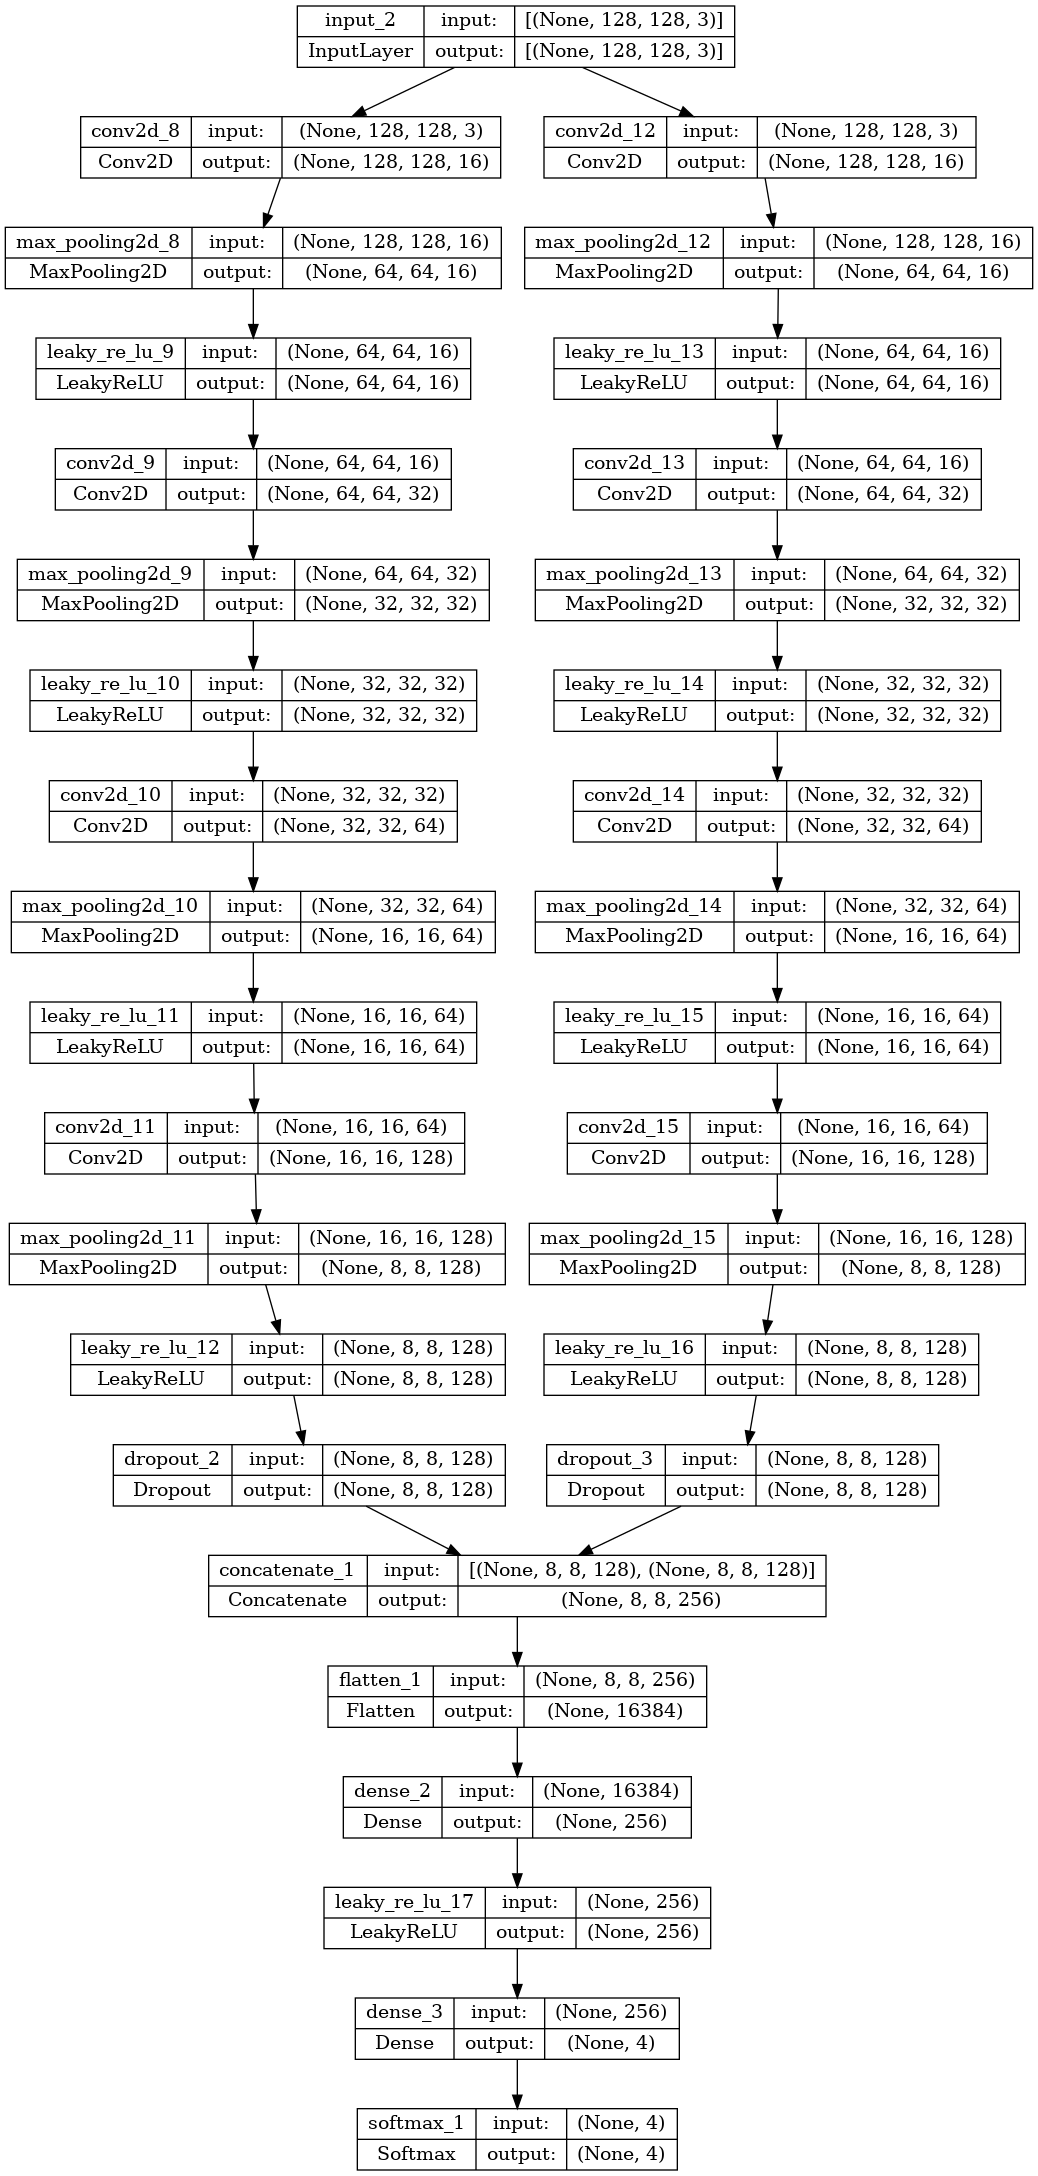

In [70]:
# plot graph
plot_model(model, to_file='shared_input_layer.png', show_shapes=True)

In [71]:
print(type(model))

<class 'keras.engine.functional.Functional'>


## Set Parameters for Training the Model

In [72]:
### model Compilation
model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])

## Defining Callback

In [73]:
# callbacks used in sequential_model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

## Training and Testing the Model

In [74]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 8
history = model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 40,
batch_size=batch_size,
callbacks = CALLBACKS
)

Epoch 1/40
943/943 [==============================] - 23s 23ms/step - loss: 0.8781 - acc: 0.5973 - auc: 0.8555 - f1_score: 0.5762 - precision: 0.7834 - recall: 0.4084 - val_loss: 0.8894 - val_acc: 0.5938 - val_auc: 0.8560 - val_f1_score: 0.6705 - val_precision: 0.6495 - val_recall: 0.5176 - lr: 0.0100
Epoch 2/40
943/943 [==============================] - 21s 23ms/step - loss: 0.3547 - acc: 0.8542 - auc: 0.9773 - f1_score: 0.8441 - precision: 0.8745 - recall: 0.8302 - val_loss: 0.6659 - val_acc: 0.7275 - val_auc: 0.9278 - val_f1_score: 0.7964 - val_precision: 0.7349 - val_recall: 0.7119 - lr: 0.0100
Epoch 3/40
943/943 [==============================] - 21s 23ms/step - loss: 0.1583 - acc: 0.9420 - auc: 0.9948 - f1_score: 0.9375 - precision: 0.9447 - recall: 0.9370 - val_loss: 0.5739 - val_acc: 0.8057 - val_auc: 0.9493 - val_f1_score: 0.8552 - val_precision: 0.8105 - val_recall: 0.8018 - lr: 0.0100
Epoch 4/40
943/943 [==============================] - 21s 22ms/step - loss: 0.0659 - acc: 0

In [75]:
### Evaluate sequential_model
test_scores = model.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

32/32 [==============================] - 1s 18ms/step - loss: 0.4931 - acc: 0.9004 - auc: 0.9713 - f1_score: 0.9207 - precision: 0.9012 - recall: 0.8994


Testing Loss : 		 0.493074
Testing Accuracy : 	 90.039062 %
Testing AC : 		 97.133952 %
Testing F1-Score : 	 92.069668 %
Testing Precision : 	 90.117419 %
Testing Recall : 	 89.941406 %


# Performance Evaluation

## Accuracy Curve

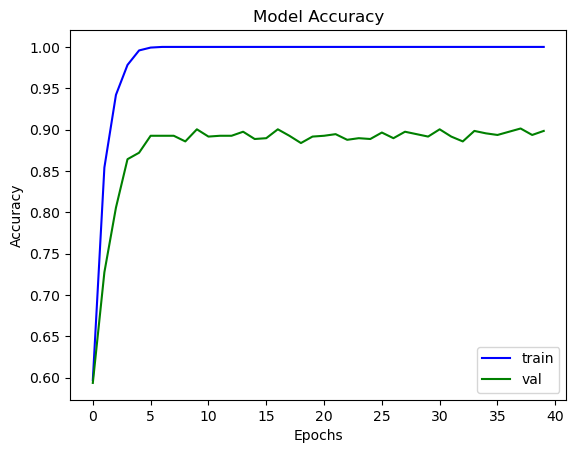

In [76]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

## Loss Curve

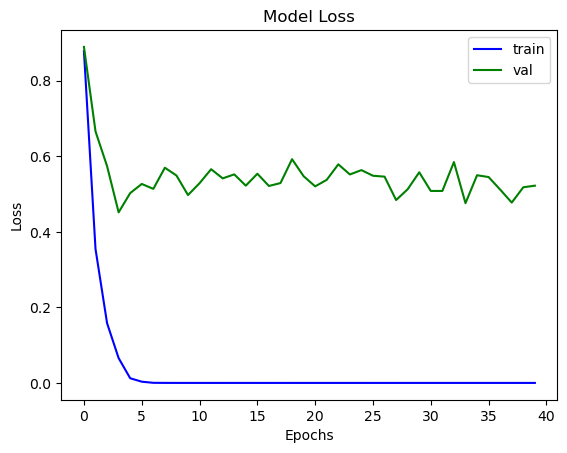

In [77]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

## AUC

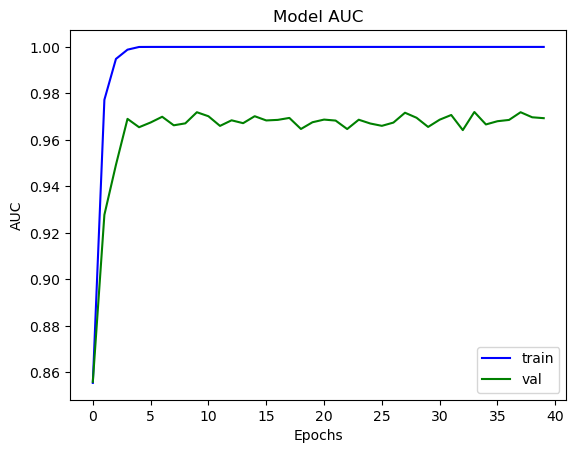

In [78]:
plt.plot(history.history['auc'], 'b')
plt.plot(history.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

## ROC Curve

In [79]:
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))

32/32 [==============================] - 1s 14ms/step
                  precision    recall  f1-score   support

    MildDemented       0.85      0.92      0.88       142
ModerateDemented       1.00      1.00      1.00         6
     NonDemented       0.95      0.88      0.92       518
VeryMildDemented       0.85      0.92      0.89       358

       micro avg       0.90      0.90      0.90      1024
       macro avg       0.91      0.93      0.92      1024
    weighted avg       0.90      0.90      0.90      1024
     samples avg       0.90      0.90      0.90      1024



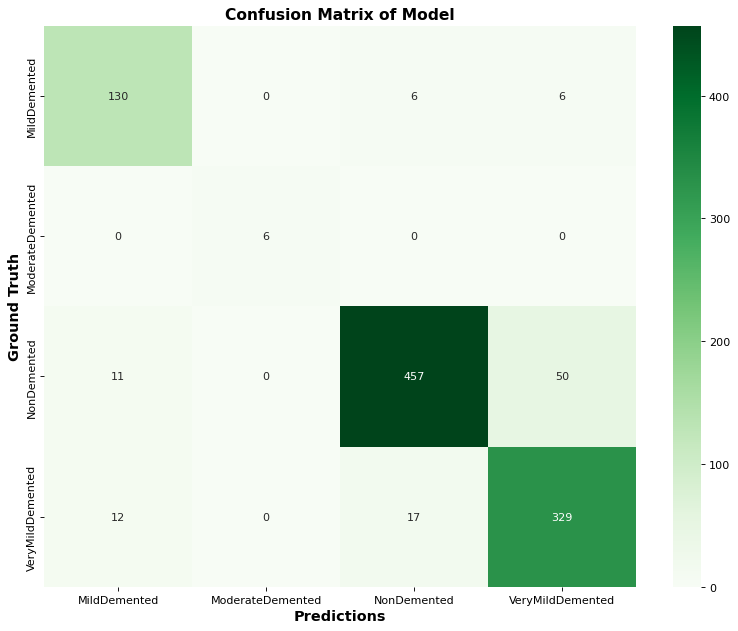

In [80]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

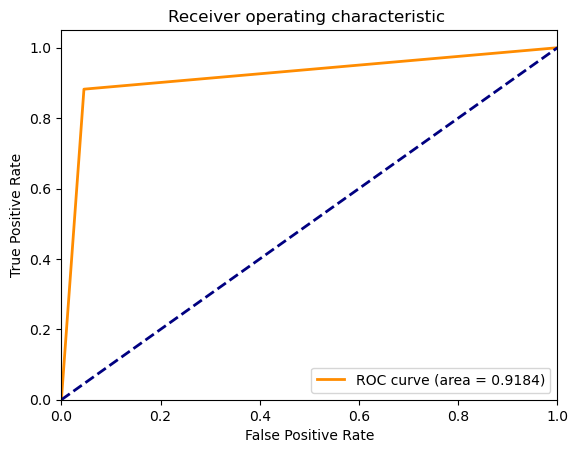

In [81]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

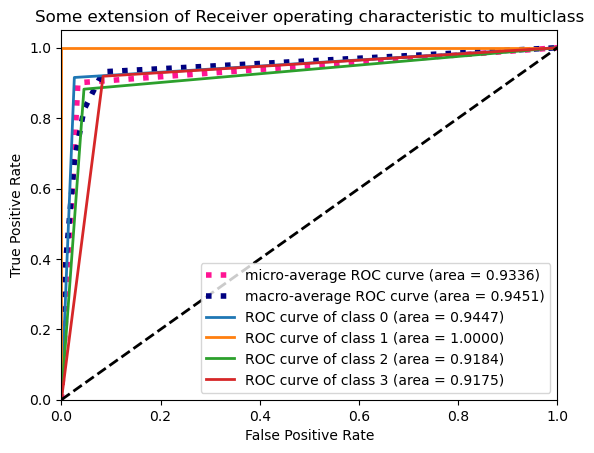

In [82]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()